In [1]:
import gc
import pandas as pd
import matplotlib.pyplot as plt
gc.enable()

In [2]:
df_core_snps = pd.read_csv("core_snps_filtered.csv", sep='\t')
df_core_snps.head()

,ref_rs_id,ref_chr,ref_bp,ref_af,ref_allele,ref_other_allele,ref_snp_num
0,rs7518469,1,4756276,0.94036,G,T,7518469
1,rs7521197,1,5758772,0.07654,C,T,7521197
2,rs429383,1,6761261,0.22760,A,G,429383
3,rs953043,1,8774451,0.29320,C,T,953043
4,rs3010876,1,12779560,0.83000,C,T,3010876


In [3]:
df_eur = pd.read_csv("eur_tables/EUR_all_chr.ld", sep='\t')
df_british = pd.read_csv("eur_tables/British_all_chr.ld", sep='\t')
df_ceph = pd.read_csv("eur_tables/CEPH_all_chr.ld", sep='\t')
df_finnish = pd.read_csv("eur_tables/Finnish_all_chr.ld", sep='\t')
df_spanish = pd.read_csv("eur_tables/Spanish_all_chr.ld", sep='\t')
df_tuscan = pd.read_csv("eur_tables/Tuscan_all_chr.ld", sep='\t')

In [4]:
df_eur.head()

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R
0,1,4756276,rs7518469,0.059642,1,4515277,rs1213919,0.489066,-0.104870
1,1,4756276,rs7518469,0.059642,1,4522799,rs651713,0.346918,0.113732
2,1,4756276,rs7518469,0.059642,1,4522965,rs652585,0.346918,0.113732
3,1,4756276,rs7518469,0.059642,1,4523232,rs687103,0.346918,0.113732
4,1,4756276,rs7518469,0.059642,1,4523390,rs687951,0.346918,0.113732


In [5]:
df_eur.shape

(945988, 9)

In [6]:
df_dict = {'eur':df_eur, 'bri':df_british, 'ceph':df_ceph, 'fin':df_finnish, 'spa':df_spanish, 'tus':df_tuscan}
for name, df in df_dict.items():
    df.drop(df[abs(df["R"])<0.2].index,inplace=True)


In [7]:
df_eur.shape

(557247, 9)

In [8]:
len(df_eur[(abs(df_eur.R) > 0.799) & (abs(df_eur.R) < 0.801)].SNP_A.unique())

158

In [9]:
df_eur['dist'] = abs(df_eur['BP_A'] - df_eur['BP_B'])

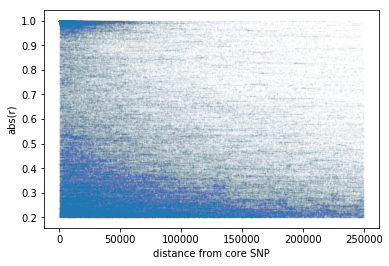

In [10]:
plt.scatter(df_eur['dist'], abs(df_eur['R']), alpha=0.01, s=0.7)
plt.xlabel("distance from core SNP")
plt.ylabel("abs(r)")
plt.show()

In [11]:
lower_threshold = 0.799
upper_threshold = 0.801

def get_snp_pairs_in_range(lower_threshold, upper_threshold):
    df_temp = df_eur[(abs(df_eur.R) > lower_threshold) & (abs(df_eur.R) < upper_threshold)].copy()
    df_temp.drop_duplicates(subset='SNP_A', inplace=True)
    df_temp = df_temp[['SNP_A', 'SNP_B', 'MAF_A', 'MAF_B']]
    for name, df in df_dict.items():
        df = df.rename(index=str, columns={"R": name}, inplace=False)
        df_temp = pd.merge(df_temp, df[['SNP_A', 'SNP_B', name]], how='inner', 
                           on=['SNP_A', 'SNP_B'])
    return df_temp

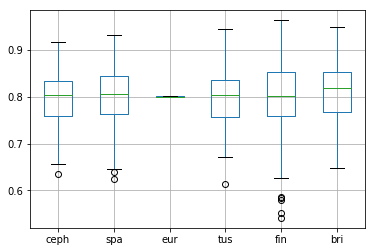

ceph    0.063386
spa     0.067593
eur     0.006102
tus     0.068219
fin     0.092379
bri     0.067592
dtype: float64


In [20]:
df_08 = get_snp_pairs_in_range(lower_threshold=0.799, upper_threshold=0.801)
abs(df_08[['ceph', 'spa', 'eur', 'tus', 'fin', 'bri']]).boxplot()
plt.show()
print(abs(df_temp[['ceph', 'spa', 'eur', 'tus', 'fin', 'bri']]).std())

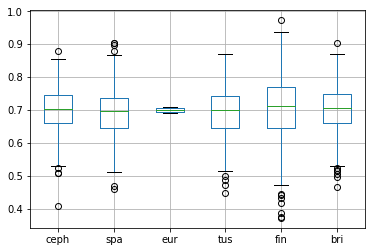

ceph    0.063386
spa     0.067593
eur     0.006102
tus     0.068219
fin     0.092379
bri     0.067592
dtype: float64


In [21]:
df_07 = get_snp_pairs_in_range(lower_threshold=0.69, upper_threshold=0.71)
abs(df_07[['ceph', 'spa', 'eur', 'tus', 'fin', 'bri']]).boxplot()
plt.show()
print(abs(df_temp[['ceph', 'spa', 'eur', 'tus', 'fin', 'bri']]).std())

# Fisher Z-transformation

In [22]:
import numpy as np
import math
from scipy.stats import norm


def get_conf_interval(r, N=100, alpha=0.05):
    z = np.arctanh(r)
    SE = 1/math.sqrt(N-3)
    z_alpha_2 = abs(norm.ppf(alpha/2))
    lower_margin = np.tanh(z - SE * z_alpha_2)
    upper_margin = np.tanh(z + SE * z_alpha_2)
    return {"lower":lower_margin, "upper":upper_margin}

In [23]:
get_conf_interval(0.8, N=100)

{'lower': 0.71610699230849739, 'upper': 0.86110830048131048}

In [24]:
get_conf_interval(0.9, N=100)

{'lower': 0.85466670526166133, 'upper': 0.93171328499056583}

In [39]:
ci = get_conf_interval(0.8, N=100)
print(ci)
for name in df_dict.keys():
    print( name, len(df_08[(abs(df_08[name]) > ci["lower"]) & (abs(df_08[name]) < ci["upper"])])/len(df_08))

{'lower': 0.71610699230849739, 'upper': 0.86110830048131048}
fin 0.6783216783216783
ceph 0.8041958041958042
eur 1.0
tus 0.7832167832167832
bri 0.7272727272727273
spa 0.7832167832167832
